In [4]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import sonnet as snt
import tqdm

from util.expectiles import expectile

print(f"Python version:      {sys.version.split()[0]}")
print(f"NumPy version:       {np.__version__}")
print(f"TensorFlow version:  {tf.__version__}")
print(f" Eager execution:     {tf.executing_eagerly()}")
print(f" GPU availability:    {bool(tf.config.experimental.list_physical_devices('GPU'))}")
print(f"Sonnet version:      {snt.__version__}")

Python version:      3.8.2
NumPy version:       1.18.1
TensorFlow version:  2.2.0-rc4
 Eager execution:     True
 GPU availability:    False
Sonnet version:      2.0.0


loading...
plotting...


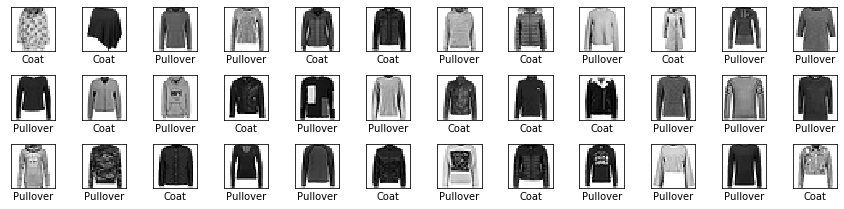

In [110]:
def rewarded_fmnist_dataset(split, batch_size, labels_to_keep):
    def label_mask(images, labels):
        mask = tf.zeros(labels.shape, tf.bool)
        for label in labels_to_keep:
            mask |= (labels == label)
        return mask
    def preprocess(images, labels):
        images = ((tf.cast(images, tf.float32) / 255.) - .5) * 2.
        return images, labels
    # load the dataset
    dataset, dataset_info = tfds.load(name="fashion_mnist", split=split,
                shuffle_files=True, as_supervised=True, with_info=True)
    dataset_size = dataset_info.splits[split].num_examples
    
    # filter out unused labels
    dataset = dataset.filter(label_mask)
    # transform images
    dataset = dataset.map(preprocess)
    # shuffle, and batch
    dataset = dataset.shuffle(buffer_size=4*batch_size)
    dataset = dataset.batch(batch_size)
    # cache the data pipeline result
    dataset = dataset.cache()
    # 'prefetch batches onto the GPU', 'automatically determine how much
    # to prefetch as this will depend on the GPU'
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset, dataset_size

print("loading...")
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
LABELS_REWARDS = { 2: [+3, -3],
                   4: [0]
                 }
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 1000
TRAIN_DATA, NUM_TRAIN_EXAMPLES = rewarded_fmnist_dataset(split="train",
            batch_size=TRAIN_BATCH_SIZE, labels_to_keep=LABELS_REWARDS.keys())
TEST_DATA, NUM_TEST_EXAMPLES = rewarded_fmnist_dataset(split="test",
            batch_size=TEST_BATCH_SIZE, labels_to_keep=LABELS_REWARDS.keys())

print("plotting...")
n, m = 3, 12
plt.figure(figsize=(m, n))
for i, (image, label) in enumerate(TEST_DATA.unbatch().take(n*m), 1):
    plt.subplot(n, m, i)
    plt.imshow(tf.squeeze(image), cmap=plt.cm.binary)
    plt.xlabel(CLASS_NAMES[label])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [111]:
model_trad = snt.Sequential([
    snt.Conv2D(32, 3, 1),
    tf.nn.relu,
    snt.Conv2D(32, 3, 1),
    tf.nn.relu,
    snt.Flatten(),
    snt.Linear(10),
    tf.nn.relu,
    snt.Linear(1) # predict value, not logits
])

model_dist = snt.Sequential([
    snt.Conv2D(32, 3, 1),
    tf.nn.relu,
    snt.Conv2D(32, 3, 1),
    tf.nn.relu,
    snt.Flatten(),
    snt.Linear(10),
    tf.nn.relu,
    snt.Linear(3) # predict some expectiles, not logits
])

In [125]:
NUM_REDUCED_IMAGES = 60160
# NUM_BATCHES_PER_EPOCH = np.ceil(NUM_REDUCED_IMAGES / TRAIN_BATCH_SIZE)
# Let's use 5 epochs
NUM_EPOCHS = 5

In [127]:
# Traditional RL model training
optimizer = snt.optimizers.SGD(learning_rate=0.1)
for minibatch in tqdm.tqdm(TRAIN_DATA.repeat(NUM_EPOCHS), unit_scale=TRAIN_BATCH_SIZE,
                    unit='images', total=(NUM_REDUCED_IMAGES / TRAIN_BATCH_SIZE)):
    images, labels = minibatch
    with tf.GradientTape() as tape:
        value_predictions = model_trad(images)
        # generate rewards
        rewards = np.zeros(TRAIN_BATCH_SIZE)
        for label, rs in LABELS_REWARDS.items():
            ids = np.where(labels == label)
            num = ids[0].size
            rewards[ids] = np.random.choice(rs, num)
        rewards = tf.convert_to_tensor(rewards, tf.float32)
        rpe = tf.subtract(rewards, value_predictions)
        # if we use this as a loss, won't the net just learn
        # to predict very low values...? something is wrong...!
        loss = tf.reduce_mean(rpe)
    variables = model_trad.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply(gradients, variables)

print("\n\nFinal loss: {}".format(loss.numpy()))

  1%|          | 60160/7700480 [01:55<4:04:00, 521.85images/s]



Final loss: nan


In [ ]:
#     def add_rewards(images, labels):
#         rewards = np.zeros(labels.shape)
#         for label, rs in labels_rewards.items():
#             ids = tf.where(labels == label)
#             num = ids.shape[0]
#             rewards[ids] = np.random.choice(rs, num)
#         return images, labels, tf.convert_to_tensor(rewards)

In [143]:
# NOISE = 0.3
# # trial logic
# def trial_1():
#     s = np.random.choice([1, 3])
#     if s == 1:
#         x = X1[np.random.choice(N1)]
#         r = np.random.choice([+1, -1])
#     if s == 3:
#         x = X3[np.random.choice(N3)]
#         r = np.random.choice([+3, -3])
#     # add noise
#     x += NOISE*np.random.random(x.shape)
#     return x, r
# def trial_2():
#     s = np.random.choice([1, 3])
#     if s == 1:
#         x = X1[np.random.choice(N1)]
#         r = np.random.choice([+1, -1])
#     if s == 3:
#         x = X3[np.random.choice(N3)]
#     # add noise
#     x += NOISE*np.random.random(x.shape)

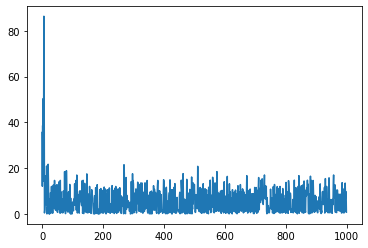

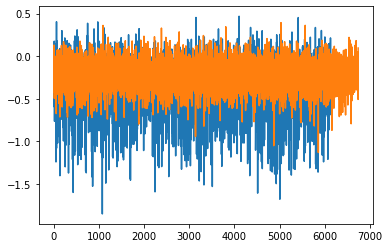

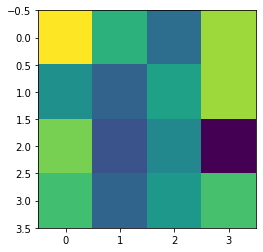

In [187]:
# NUM_EPISODES = 1000

# # model
# w = np.random.random(16)
# a = 0.01

# # task 1
# ds = []
# ws = []
# for ep in range(NUM_EPISODES):
#     x, r = trial_1()
#     d = r - w @ x
#     w = w + a * d * x
#     ds.append(d)
#     ws.append(w)
# plt.plot(np.square(ds))
# plt.show()
# plt.plot(X3 @ w)
# plt.plot(X1 @ w)
# plt.show()

# plt.imshow(w.reshape(4,4))
# plt.show()


In [ ]:
# NUM_EPISODES = 1000

# # model
# w1 = np.random.random(16)
# w2 = np.random.random(16)
# w3 = np.random.random(16)
# a = 0.01

# # task 1
# ds = []
# ws = []
# for ep in range(NUM_EPISODES):
#     x, r = trial_1()
#     d = r - w @ x
#     w = w + a * d * x
#     ds.append(d)
#     ws.append(w)
# plt.plot(np.square(ds))
# plt.show()
# plt.plot(X3 @ w)
# plt.plot(X1 @ w)
# plt.show()

# plt.imshow(w.reshape(4,4))
# plt.show()


In [5]:
# import sklearn.datasets

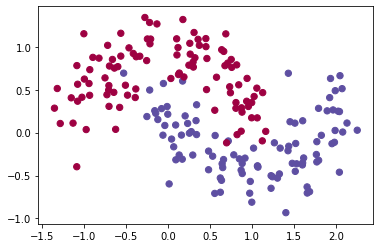

In [6]:
# np.random.seed(0)
# X, y = sklearn.datasets.make_moons(200, noise=0.20)
# plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [50]:
# def softmax(X):
#     Y = np.exp(X)
#     Z = np.sum(Y, axis=1)
#     return Y / Z[:, np.newaxis]
# def grad__softmax(Y):
#     return (np.eye(Y.shape[0])[None]-Y[:,None])*Y[:,:,None]
# def sigmoid(X):
#     return 1 / (1 + np.exp(-X))
# def grad__sigmoid(Y):
#     return (1-Y)*Y
# class NN():
#     def __init__(self, layers, activations, activation_gradients, seed=42):
#         np.random.seed(42)
#         self.W = [2*np.random.random((ni, no))-1 for ni, no in zip(layers, layers[1:])]
#         self.s = activations
#         self.g = activation_gradients
#     def predict(self, X):
#         if X.ndim == 1:
#             return self.__forward(np.atleast_2d(X))[0][0]
#         else:
#             return self.__forward(X)[0]
#     def __forward(self, X):
#         zs = []
#         Z = X
#         for W, s in zip(self.W, self.s):
#             Z = s(Z @ W)
#             zs.append(Z)
#         return Z, zs
# # I hate this

In [1]:
# nn = NN([16, 10, 2], [sigmoid, softmax], [grad__sigmoid, grad__softmax])
# print(nn.predict(X1[0]))